# Customer Segmentation Problem
The Starbucks Capstone Project focuses on the Business Analytics domain of the American
coffee company and fast-food chain, Starbucks . It involves analysing how promotional offers
affect purchasing decisions, taking into consideration certain traits of the buyers such as age,
gender, income and even whether the buyer likes to receive offers.

Analysis is be done using customer segmentation. This is therefore a classification problem
where given the input data containing demographic, transactional and offer information of
various customers, subgroups containing very similar data points are created and examined to
deduce how demographic attributes relate to offer types and behaviour towards offers.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Machine Learning Workflow
To implement customer segmentation in this project, we would go through a number of steps.

1. Data Loading and Exploration
2. Data Cleaning and Preprocessing
3. Dimensionality Reduction using Principal Components Analysis
4. Feature Engineering and Data Transformation
5. Clustering Transformed Data with GMM
6. Extracting trained model attributes and visualizing clusters


## Loading the Datasets
First, the relevant libraries are imported. Then the json files containing the datasets are loaded. 

In [1]:
import pandas as pd
import numpy as np
import math
import json
from data_preprocessing import merge_datasets, create_new_features, group_by_customers
from clean_data import missing_val_check, impute_missing_vals
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

The datsets are examined to find out the columns, number of instances and features

In [2]:
print("portfolio:\nNumber of rows:{}, Number of columns:{}".format(portfolio.shape[0], portfolio.shape[1]))
portfolio

portfolio:
Number of rows:10, Number of columns:6


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
print("profile:\nNumber of rows:{}, Number of columns:{}".format(profile.shape[0], profile.shape[1]))
profile.head()

profile:
Number of rows:17000, Number of columns:5


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
print("transcript:\nNumber of rows:{}, Number of columns:{}".format(transcript.shape[0], transcript.shape[1]))
transcript.head()

transcript:
Number of rows:306534, Number of columns:4


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## Exploratory Data Analysis
Now that the data has been loaded, it is then cleaned, explored and preprocessed. This involves (in no particular order):

- Checking for the unique and missing values in columns. 
- Using visualizations to examine patterns in the datasets
- Merging the datasets to become a more detailed set to be used in the learning algorithm
- Converting Categorical data to numeric data

### Checking for Unique and Missing Values in columns
First, columns in the datasets are checked for missing values. 

In [5]:
print([missing_val_check(dataset) for dataset in [portfolio, profile, transcript]])

[[], ['gender', 'income'], []]


There seems to be some missing values in the 'gender' and 'income' columns of the 'profile' dataset. The amount of missing values in these columns is checked

In [6]:
for col in ['gender', 'income']:
    print("Col: {0}\n Amount of missing values:{1}, Percentage:{2}\n\n"
          .format(col, profile[col].isnull().sum(), (profile[col].isnull().sum()/profile.shape[0])))

Col: gender
 Amount of missing values:2175, Percentage:0.12794117647058822


Col: income
 Amount of missing values:2175, Percentage:0.12794117647058822




12 percent of the data is missing in both columns. Dropping the columns is a not a good idea since both features are relevant. Dropping the rows with the missing values is also a bad idea because we would be losing a good amount of customer information.
These missing values will be dealt with using imputation later on.

Then, certain features in the datasets are examined to discover unique values and their counts. First, the 'event' and 'value' features in the transcript dataset are examined to identify the types of events and the values for such events.

In [7]:
# We check for the unique events in the 'event' feature of the transcript
# dataset. This feature shows the type of event which took place for each 
# transaction.

transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [8]:
# We also check for the unique values in the 'value' dataset

transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

From the cell above we can see that the variables in the 'value' dataset are in 3 forms:
- A dictionary containing one key-value pair where the key is 'offer id'.
- A dictionary containing one key-value pair where the key is 'amount'.
- A dictionary containing 2 key-value pairs where the keys are 'offer id' and 'reward'. 

Next I examine how these variables are associated with each type of event.

In [9]:
for event in transcript['event'].unique():
    display(event, transcript.loc[transcript['event'] == event].head())

# transcript.sample(n=5)

'offer received'

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


'offer viewed'

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


'transaction'

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


'offer completed'

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


We can see that the 'offer received' and 'offer viewed' events are associated with the value {'offer id':'...'}, the 'offer completed' event is associated with the value {'offer id':'...', 'reward':'...'} and the nature of the value for the 'transaction' event is {'amount':...}; which makes complete sense. 

### Merging the Datasets

First, the profile dataset is merged with the transactions dataset so each transaction has a customer profile attached to it.

Then I create a new feature 'unzipped_value' to store the values in each dictionary in the 'value' feature. For the value which corresponds to the 'offer completed' event i.e the one containing two keys: 'offer id' and 'reward', I only retain the value for 'offer id' as I might not necessarily need the reward value.

In [10]:
profile_transcript = merge_datasets(profile, transcript)
print(profile_transcript.shape)
profile_transcript.head()

(306534, 9)


,age,became_member_on,gender,income,event,person,time,value,unzipped_value
0,118,20170212,None,NaN,offer received,68be06ca386d4c31939f3a4f0e3dd783,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
1,118,20170212,None,NaN,offer viewed,68be06ca386d4c31939f3a4f0e3dd783,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
2,118,20170212,None,NaN,offer received,68be06ca386d4c31939f3a4f0e3dd783,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
3,118,20170212,None,NaN,offer viewed,68be06ca386d4c31939f3a4f0e3dd783,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
4,118,20170212,None,NaN,transaction,68be06ca386d4c31939f3a4f0e3dd783,360,{'amount': 0.35000000000000003},0.35


I also check to see if we got the expected result for the 'offer_completed' event.

In [11]:
profile_transcript.loc[profile_transcript['event'] == 'offer completed'].head(2)

,age,became_member_on,gender,income,event,person,time,value,unzipped_value
14,118,20170212,None,NaN,offer completed,68be06ca386d4c31939f3a4f0e3dd783,552,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4
15,118,20170212,None,NaN,offer completed,68be06ca386d4c31939f3a4f0e3dd783,552,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,2298d6c36e964ae4a3e7e9706d1fb8c2



### Grouping Customers by Transactions
The profile_transcript dataset contains the different transactions performed by each customer. In this section, the customers would be grouped based on the following features.

- Number of purchases made
- Number of offers received
- Number of offers completed
- Number of offers viewed
- How each customer relates to each offer i.e was the offer received? was the offer viewed? etc.
- Total amount of money spent
 

#### Creating the New Features
First we create the new features stated above.

In [13]:
new_dataset = create_new_features(profile_transcript)

# We take a look at the new columns created
new_columns = list(new_dataset.columns)[profile_transcript.shape[1]:]
print("New features:")
print(new_columns)
print("Number of new features: {}".format(len(new_columns)))
new_dataset.head()

New features:
['total_purchases', 'total_offers_received', 'total_offers_viewed', 'total_offers_completed', 'bogo_ae264_Rcvd', 'bogo_ae264_Vwd', 'bogo_ae264_Cmpltd', 'bogo_4d5c5_Rcvd', 'bogo_4d5c5_Vwd', 'bogo_4d5c5_Cmpltd', 'info_3f207_Rcvd', 'info_3f207_Vwd', 'info_3f207_Cmpltd', 'bogo_9b98b_Rcvd', 'bogo_9b98b_Vwd', 'bogo_9b98b_Cmpltd', 'disc_0b1e1_Rcvd', 'disc_0b1e1_Vwd', 'disc_0b1e1_Cmpltd', 'disc_2298d_Rcvd', 'disc_2298d_Vwd', 'disc_2298d_Cmpltd', 'disc_fafdc_Rcvd', 'disc_fafdc_Vwd', 'disc_fafdc_Cmpltd', 'info_5a8bc_Rcvd', 'info_5a8bc_Vwd', 'info_5a8bc_Cmpltd', 'bogo_f1942_Rcvd', 'bogo_f1942_Vwd', 'bogo_f1942_Cmpltd', 'disc_2906b_Rcvd', 'disc_2906b_Vwd', 'disc_2906b_Cmpltd', 'total_spend']
Number of new features: 35


,age,became_member_on,gender,income,event,person,time,value,unzipped_value,total_purchases,...,info_5a8bc_Rcvd,info_5a8bc_Vwd,info_5a8bc_Cmpltd,bogo_f1942_Rcvd,bogo_f1942_Vwd,bogo_f1942_Cmpltd,disc_2906b_Rcvd,disc_2906b_Vwd,disc_2906b_Cmpltd,total_spend
0,118,20170212,None,NaN,offer received,68be06ca386d4c31939f3a4f0e3dd783,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,...,0,0,0,0,0,0,1,0,0,0.00
1,118,20170212,None,NaN,offer viewed,68be06ca386d4c31939f3a4f0e3dd783,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0,...,0,0,0,0,0,0,0,1,0,0.00
2,118,20170212,None,NaN,offer received,68be06ca386d4c31939f3a4f0e3dd783,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,...,0,0,0,0,0,0,0,0,0,0.00
3,118,20170212,None,NaN,offer viewed,68be06ca386d4c31939f3a4f0e3dd783,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0,...,0,0,0,0,0,0,0,0,0,0.00
4,118,20170212,None,NaN,transaction,68be06ca386d4c31939f3a4f0e3dd783,360,{'amount': 0.35000000000000003},0.35,1,...,0,0,0,0,0,0,0,0,0,0.35


Now there are 35 new features. Some of the older features such as 'value', 'event' and 'unzipped_value' are not so relevant anymore since newer features have been created from them. 

#### Grouping the Dataset by Customer Id and Demographic Information
Next, the dataset is grouped by the customer id and demographic information and the sum of each of the new columns is calculated for each customer. This would give a new dataset having only the features needed. Before creating this dataset, missing values are dealt with in order to avoid misplacing some customer information. 

In [14]:
impute_missing_vals(new_dataset)
customer_dataset = group_by_customers(new_dataset)
print("No. of  customers: {}".format(customer_dataset.shape[0]))
print("No. of features in customer_dataset: {}".format(customer_dataset.shape[1]))
customer_dataset.head()

No. of  customers: 17000
No. of features in customer_dataset: 39


,age,gender,became_member_on,income,total_purchases,total_offers_received,total_offers_viewed,total_offers_completed,bogo_ae264_Rcvd,bogo_ae264_Vwd,...,info_5a8bc_Rcvd,info_5a8bc_Vwd,info_5a8bc_Cmpltd,bogo_f1942_Rcvd,bogo_f1942_Vwd,bogo_f1942_Cmpltd,disc_2906b_Rcvd,disc_2906b_Vwd,disc_2906b_Cmpltd,total_spend
person,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,33,M,20170421,72000.0,8,5,4,3,0,0,...,1,1,0,1,1,1,1,0,1,127.60
00116118485d4dfda04fdbaba9a87b5c,118,gender_unavailable,20180425,0.0,3,2,2,0,0,0,...,0,0,0,2,2,0,0,0,0,4.09
0011e0d4e6b944f998e987f904e8c1e5,40,O,20180109,57000.0,5,5,5,3,0,0,...,1,1,0,0,0,0,0,0,0,79.46
0020c2b971eb4e9188eac86d93036a77,59,F,20160304,90000.0,8,5,3,3,1,0,...,1,1,0,0,0,0,0,0,0,196.86
0020ccbbb6d84e358d3414a3ff76cffd,24,F,20161111,60000.0,12,4,4,3,0,0,...,1,1,0,1,1,1,0,0,0,154.05


From the dataset above, we note the following: 
- The contains information of every customers demographic information as well as the number of purchases made, offers received, offers viewed and offers completed.
- It also shows the number of times a customer received, viewed and completed each of the offers. Offer features have been renamed to be in the format `offertype_offerid[:5]_event`. For example, a bogo offer with id '2906b810c7d4411798c6938adc9daaa5' is renamed as 'bogo_2906b_received'.

Since Informational offers don't have any form of completion, we delete all features representing completion of informational offers. 

In [15]:
info_complt_cols = [col for col in new_columns if col[:4] == "info" and col[-6:] == "Cmpltd"]
customer_dataset.drop(info_complt_cols, axis=1, inplace=True)
print("Features removed: {}".format(info_complt_cols))
print("Number of Features left: {}".format(customer_dataset.shape[1]))
print("Features left: {}".format(customer_dataset.columns))

Features removed: ['info_3f207_Cmpltd', 'info_5a8bc_Cmpltd']
Number of Features left: 37
Features left: Index(['age', 'gender', 'became_member_on', 'income', 'total_purchases',
       'total_offers_received', 'total_offers_viewed',
       'total_offers_completed', 'bogo_ae264_Rcvd', 'bogo_ae264_Vwd',
       'bogo_ae264_Cmpltd', 'bogo_4d5c5_Rcvd', 'bogo_4d5c5_Vwd',
       'bogo_4d5c5_Cmpltd', 'info_3f207_Rcvd', 'info_3f207_Vwd',
       'bogo_9b98b_Rcvd', 'bogo_9b98b_Vwd', 'bogo_9b98b_Cmpltd',
       'disc_0b1e1_Rcvd', 'disc_0b1e1_Vwd', 'disc_0b1e1_Cmpltd',
       'disc_2298d_Rcvd', 'disc_2298d_Vwd', 'disc_2298d_Cmpltd',
       'disc_fafdc_Rcvd', 'disc_fafdc_Vwd', 'disc_fafdc_Cmpltd',
       'info_5a8bc_Rcvd', 'info_5a8bc_Vwd', 'bogo_f1942_Rcvd',
       'bogo_f1942_Vwd', 'bogo_f1942_Cmpltd', 'disc_2906b_Rcvd',
       'disc_2906b_Vwd', 'disc_2906b_Cmpltd', 'total_spend'],
      dtype='object')


### Data Visualizations
We take a look at characteristics and relationships of some of the features. First we examine the distribution of the 'gender' and 'age' features. 

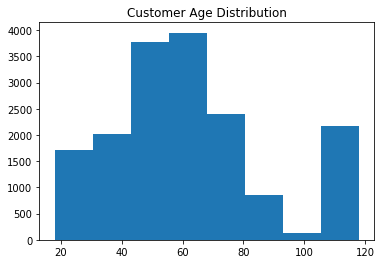

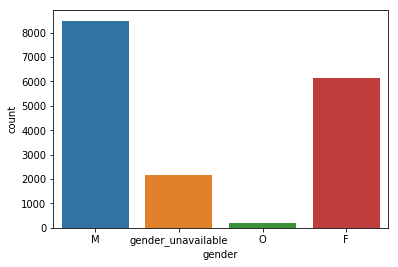

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram to show the distribution of the 'age' feature
plt.hist(x= customer_dataset['age'], bins=8)
plt.title("Customer Age Distribution")
plt.show()

# Create a count plot to show the distribution of the 'gender' feature
sns.countplot(x='gender', data=customer_dataset)

From the above, we can deduce that most of the customers are within the ages 40 to 60 and most are also male. Then we examine the distribution of customers income, total_purchases, total_offers_received, total_offers_viewed,
total_offers_completed and total_spend.

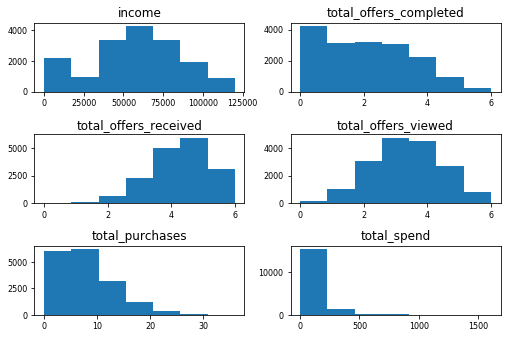

In [17]:
customer_dataset.hist(column= ['income',  'total_purchases', 'total_offers_received', 
                               'total_offers_viewed', 'total_offers_completed', 'total_spend'], bins=7, linewidth=1.0, 
                      xlabelsize=8, ylabelsize=8, grid=False) 
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

The following observations are made from the histograms:

- Most customers earn between 50000 and 75000
- Most customers received between 4 and 5 offers
- Most viewed between 3 and 4 offers
- Most didn't complete offers
- Most customers made between 5 to 10 purchases

Next we examine the relationship between the 'total_purchases' feature and the 'gender', 'age' and 'income' feature.

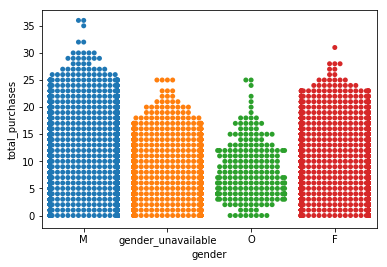

In [18]:
# We create a swarm plot to visualize how each gender made purchases
sns.swarmplot(x=customer_dataset['gender'],
              y=customer_dataset['total_purchases'])

From the swarm plot above, the highest number of total purchases were made by the male gender.

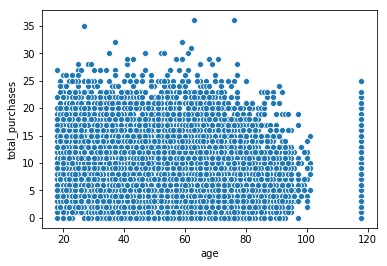

In [19]:
# Create scatter plot showing relationship between the 'age' and 'total_purchases' features.

sns.scatterplot(x='age', y='total_purchases', 
                data=customer_dataset)

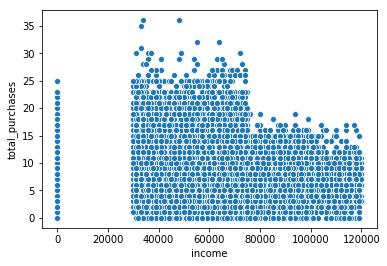

In [20]:
# Create a scatter plot showing the relationship between 'income' and 'total_purchases'
sns.scatterplot(x='income', y='total_purchases', 
                data=customer_dataset)

From the scatterplot above, the highest number of purchases were made by those between 25-80 years of age and those earning between 30,000 to 60,000.

### Dealing with Categorical Features and Normalizing Numerical Features
The only categorical feature left is the 'gender' feature. We deal with this using One Hot encoding and Column Transformer. Then numerical features are also normalized in order to consistently compare the values of different features.

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Select the categorical and numerical features
categorical_cols = [col for  col in customer_dataset.columns
                   if customer_dataset[col].dtype == 'object']

numerical_cols = [col for col in customer_dataset.columns
                 if customer_dataset[col].dtype in ['int64', 'float64']]

# Create transformers for the categorical and numerical features
numerical_transformer = MinMaxScaler()
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False)),
    ('normalize', MinMaxScaler())
])

# Perform a Column Transformer on the features
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', numerical_transformer, numerical_cols)
    ])

# Create a list of the new_columns
gender_cols = ['gender_{}'.format(i) for i in ['F','M','O','unavailable']]
older_cols = list(customer_dataset.columns)
older_cols.remove('gender')
col_names = gender_cols + older_cols

# Transform the dataset
scaled_dataset = pd.DataFrame(preprocessor.fit_transform(customer_dataset), index=customer_dataset.index, 
                              columns=col_names)        
print("Number of Features: {}".format(scaled_dataset.shape[1]))
scaled_dataset.head()

Number of Features: 40


C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,gender_F,gender_M,gender_O,gender_unavailable,age,became_member_on,income,total_purchases,total_offers_received,total_offers_viewed,...,disc_fafdc_Cmpltd,info_5a8bc_Rcvd,info_5a8bc_Vwd,bogo_f1942_Rcvd,bogo_f1942_Vwd,bogo_f1942_Cmpltd,disc_2906b_Rcvd,disc_2906b_Vwd,disc_2906b_Cmpltd,total_spend
person,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.0,1.0,0.0,0.0,0.15,0.793888,0.600,0.222222,0.833333,0.666667,...,0.25,0.2,0.2,0.2,0.2,0.333333,0.25,0.0,0.25,0.079319
00116118485d4dfda04fdbaba9a87b5c,0.0,0.0,0.0,1.0,1.00,0.993980,0.000,0.083333,0.333333,0.333333,...,0.00,0.0,0.0,0.4,0.4,0.000000,0.00,0.0,0.00,0.002542
0011e0d4e6b944f998e987f904e8c1e5,0.0,0.0,1.0,0.0,0.22,0.987659,0.475,0.138889,0.833333,0.833333,...,0.00,0.2,0.2,0.0,0.0,0.000000,0.00,0.0,0.00,0.049394
0020c2b971eb4e9188eac86d93036a77,1.0,0.0,0.0,0.0,0.41,0.591535,0.750,0.222222,0.833333,0.500000,...,0.50,0.2,0.2,0.0,0.0,0.000000,0.00,0.0,0.00,0.122373
0020ccbbb6d84e358d3414a3ff76cffd,1.0,0.0,0.0,0.0,0.06,0.607676,0.500,0.333333,0.666667,0.666667,...,0.00,0.2,0.2,0.2,0.2,0.333333,0.00,0.0,0.00,0.095761


The final dataset has 40 features which means each data point (i.e each customer) has 40 features.

## Data Modeling 

### Dimensionality Reduction Using Principal Component Analysis (PCA)
The final dataset has 39 features which means the data is 39-dimensional. To perform customer segmentation, clusters would have to be created from the data and clustering algorithms rely on finding clusters in n-dimensional feature space.

Since the dimension of the data is very high, we would need to figure out which features are most important in order to avoid noisy clusters. In order words, we need to find features that help separate and group the data (features causing the most variance). 

Using PCA, dimensionality reduction is performed to find smaller set of features that help separate the data.

In [22]:
from sklearn.decomposition import PCA

# We keep only 38 components
pca = PCA(n_components=30, random_state=1)
pca.fit(scaled_dataset)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)

We take a look at the model attributes

In [23]:
# The principal component is a linear combination of the original 40 features.
# Hence the array of shape (38, 40)
princip_comp = pca.components_
print(princip_comp.shape)
princip_comp

(30, 40)


array([[ 6.74098476e-01, -7.26925324e-01,  3.52589860e-03, ...,
         7.94627712e-03,  1.18553370e-02,  1.77719910e-02],
       [-3.36341879e-01, -2.83968030e-01,  5.16431759e-03, ...,
         2.50417795e-03, -5.19679916e-02, -5.87768516e-02],
       [-1.51796051e-01, -3.19080212e-02,  1.06713547e-02, ...,
         7.47537538e-02,  8.75125193e-02,  8.38332553e-02],
       ...,
       [ 3.18276976e-03,  1.15481931e-04,  5.13472517e-03, ...,
         4.37911143e-02,  2.15874724e-01,  4.57507981e-02],
       [-8.36262928e-04,  2.18656375e-04, -4.23981841e-03, ...,
        -1.01455651e-01,  1.39563512e-01,  7.13632748e-02],
       [ 1.29999560e-02,  1.59744619e-02,  2.04731384e-02, ...,
        -1.51737707e-02,  5.82781813e-03,  9.31478230e-01]])

In [24]:
# The amount of variance explained by each of the components

explained_var = pca.explained_variance_
print(explained_var.shape)
explained_var

(30,)


array([0.42649829, 0.27132498, 0.11665626, 0.0675101 , 0.06477705,
       0.05913352, 0.05646409, 0.05291928, 0.05098193, 0.04882952,
       0.04686918, 0.04303642, 0.03727256, 0.03436364, 0.02443512,
       0.02120638, 0.01791433, 0.01186253, 0.00923067, 0.00865236,
       0.00742983, 0.00623409, 0.00614536, 0.00573929, 0.00531868,
       0.00516698, 0.00508687, 0.00473511, 0.00416256, 0.00316683])

In [25]:
singular_vals = pca.singular_values_
print(singular_vals.shape)
singular_vals

(30,)


array([85.14719281, 67.91357216, 44.53133544, 33.87630729, 33.18350592,
       31.70505802, 30.9811715 , 29.99291194, 29.43878117, 28.81063993,
       28.22639319, 27.04766409, 25.17133822, 24.16914428, 20.3806932 ,
       18.98650406, 17.45066298, 14.20039029, 12.52646068, 12.12771391,
       11.23831084, 10.29433062, 10.22080914,  9.87735532,  9.50853645,
        9.37194955,  9.29901909,  8.97174369,  8.41185449,  7.33709038])

The PCA model creates 38 principal components as instructed to. But in order to reduce the dimensionality, the top n principal components that account for at least 80% variance are selected. From the singular_values_ attribute, we can get an approximation of the data variance that is covered in the first top n-principal components by calculating the **explained variance** of these components. The top principal components are the  largest values singular_values_ attribute. For instamce, the top 5 components include:

In [26]:
singular_vals[:5]

array([85.14719281, 67.91357216, 44.53133544, 33.87630729, 33.18350592])

To calculate the explained variance, we calculate: 
**The sum of squared s values for all top n components over the sum of squared s values for all components**

In [27]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    # calculate approx variance
    exp_variance = np.square(s[:n_top_components]).sum() / np.square(s).sum()
    
    return exp_variance

exp_var_list = [explained_variance(singular_vals, i) for i in list(range(15))]
exp_var_list

[0.0,
 0.2800155120088935,
 0.4581526910158691,
 0.5347428304746349,
 0.5790662796631101,
 0.6215953567910227,
 0.6604192001820084,
 0.697490438515863,
 0.732234348124183,
 0.7657063026176525,
 0.7977651003300844,
 0.8285368503326039,
 0.8567922171799425,
 0.8812633476353549,
 0.903824639829288]

From the result above, we see that there is 80% variance from the top 11 components. I decide to use the top 11 components.

### Feature Engineering and Data Transformation
Now we transform our scaled_dataset using the PCA model created and then take the largest n components to reduce the dimensionality of our data.

In [28]:
transformed_data = pca.transform(scaled_dataset)
print(transformed_data.shape)
transformed_data

(17000, 30)


array([[-6.15340395e-01, -3.29664185e-01,  1.26927246e-01, ...,
         3.32286539e-02, -2.15966796e-02, -7.96986876e-03],
       [ 1.51922642e-01,  1.36550092e+00, -2.72429357e-01, ...,
        -1.50041558e-02, -2.29396381e-02,  4.05619951e-03],
       [ 1.27473104e-01,  5.08064681e-02,  2.23052213e-01, ...,
        -3.64193691e-02,  1.20338689e-03, -4.29795171e-03],
       ...,
       [-6.43508386e-01,  9.04364633e-02, -5.17068143e-01, ...,
        -6.12977102e-02,  1.45054943e-01, -1.51816832e-02],
       [-6.22721371e-01, -2.16857788e-01,  1.50982147e-01, ...,
        -6.52001644e-02,  1.08368416e-02, -1.51214321e-02],
       [ 8.52650203e-01, -5.13640175e-01,  7.33543404e-01, ...,
         3.44938759e-03, -8.34764690e-03, -1.19176463e-02]])

For each of our data points, we get the top n component values from the list of component data points, returned by our predictor above, and put those into a new DataFrame.

In [29]:
# Instantiate new dataframe
transformed_dataframe = pd.DataFrame(transformed_data)

# index by customers just like the customer_dataset
transformed_dataframe.index = customer_dataset.index

# Then we reduce the number of components to 12.
transformed_dataframe = transformed_dataframe.iloc[:,:12]

# Create names of features 
feature_comp = ['c_{}'.format(i) for i in list(range(1,13))]

transformed_dataframe.columns = feature_comp

transformed_dataframe.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12
person,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,-0.615340,-0.329664,0.126927,-0.132461,0.069794,0.094561,-0.400128,0.011124,0.299893,0.134199,0.146107,-0.009218
00116118485d4dfda04fdbaba9a87b5c,0.151923,1.365501,-0.272429,-0.100232,-0.155957,0.123140,-0.317206,0.230466,-0.123862,0.078571,-0.309598,-0.223620
0011e0d4e6b944f998e987f904e8c1e5,0.127473,0.050806,0.223052,0.336513,-0.060218,0.062768,-0.187344,-0.361671,-0.181650,-0.251142,-0.025479,0.448502
0020c2b971eb4e9188eac86d93036a77,0.805938,-0.340078,0.027258,-0.201594,0.172849,-0.234618,0.183462,-0.006260,0.436933,-0.064390,-0.182824,-0.109084
0020ccbbb6d84e358d3414a3ff76cffd,0.776093,-0.396541,0.066999,0.180301,-0.253869,0.042908,-0.202317,0.236364,-0.098734,-0.342883,0.231328,-0.123198


In [ ]:
pca_score = pca.score_samples(scaled_dataset)
pca_score

## Clustering Transformed Data 

Now we go ahead to cluster the data. The GMM algorithm is used and and accuracy is measured using silhouette scores. 
The benchmark algorithm would be the K-means clustering algorithm

### Benchmark Model - KMeans Clustering Algorithm

First we perform our clustering using the k-means algorithm to set a bench mark for the GMM and DBScan algorithms. The silhoutte score is used to determine the optimal number of clusters and accuracy of clustering

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

for cluster in range(2,8):
    kmeans = KMeans(init = 'k-means++', n_init = 40, n_clusters = cluster, max_iter=600)
    kmeans.fit(transformed_dataframe)
    clusters = kmeans.predict(transformed_dataframe)
    silhouette_avg = silhouette_score(transformed_dataframe, clusters)
    print("For n_clusters =", cluster, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.31340997267908727
For n_clusters = 3 The average silhouette_score is : 0.40328860761643825
For n_clusters = 4 The average silhouette_score is : 0.27762801986987773
For n_clusters = 5 The average silhouette_score is : 0.19244042602932462
For n_clusters = 6 The average silhouette_score is : 0.18584359506849848
For n_clusters = 7 The average silhouette_score is : 0.1730539014851372


From the result above, the optimal number of clusters is 3. I take a look at the number of data points in each cluster.

In [31]:
kmeans = KMeans(init = 'k-means++', n_init = 40, n_clusters = 3, max_iter=600)
km_clusters = kmeans.fit_predict(transformed_dataframe)
cluster_data_points = pd.Series(km_clusters).value_counts()
print()
print(cluster_data_points)


1    8566
0    6259
2    2175
dtype: int64


### Guassian Mixed Models

GMM models each cluster with a different Guassian distribution which results in the soft assignment of data points to clusters i.e. each data point is assigned to a cluster based on probability.
Using the GMM algorithm, we create 3 clusters

In [35]:
gmm = GaussianMixture(n_components=3)
gmm_clusters = gmm.fit_predict(transformed_dataframe)
silhouette_avg = silhouette_score(transformed_dataframe, gmm_clusters)
    
print("The GMM silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.40278647052464367


In [32]:

from sklearn.mixture import GaussianMixture
for cov_type in ['tied', 'full', 'diag','spherical']:
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type)
    gmm_clusters = gmm.fit_predict(transformed_dataframe)
    silhouette_avg = silhouette_score(transformed_dataframe, gmm_clusters)
    
    print("For",cov_type,"The average silhouette_score is :", silhouette_avg)

For tied The average silhouette_score is : 0.40278647052464367
For full The average silhouette_score is : 0.40278647052464367
For diag The average silhouette_score is : 0.40278647052464367
For spherical The average silhouette_score is : 0.40334750093084665


From the silhouette scores gotten above, it can be observed that the only covariance type which performs a little bit above the K-means clustering algorithm is the Spherical covariance type. This explains the close results gotten with the K-means clustering as K-means creates only Spherical clustering.

To visualize the number of data points in each cluster;

In [37]:
gmm = GaussianMixture(n_components=3, covariance_type='spherical', max_iter=300, 
                      n_init=3, random_state=0, init_params='random')
gmm_clusters = gmm.fit_predict(transformed_dataframe)
silhouette_avg = silhouette_score(transformed_dataframe, gmm_clusters)
print(silhouette_avg)
pd.Series(gmm_clusters).value_counts()

0.40334750093084665


2    8582
1    6243
0    2175
dtype: int64

Although the silhouette score is not very high for the GMM algorithm, it is slightly higher than that of the K-Means. We go ahead to examine the clusters and probabilistic cluster assignment of a few samples.


In [38]:
print(gmm_clusters[:5])
probs = gmm.predict_proba(transformed_dataframe)
print(probs[:5].round(3))

[2 0 1 1 1]
[[1.   0.   0.  ]
 [0.   0.   1.  ]
 [0.43 0.57 0.  ]
 [0.   1.   0.  ]
 [0.   1.   0.  ]]


## Extracting trained model attributes and visualizing clusters
Then we view the centroid of each cluster. The centroids would be used to observe the properties of each cluster.

In [39]:
cluster_centroids = pd.DataFrame(gmm.means_, columns=feature_comp)
cluster_centroids

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12
0,-0.612602,-0.150743,-0.007646,0.001473,0.002178,0.000226,-0.001427,-0.000996,-0.000519,0.000074,-0.000016,0.001210
1,0.785608,-0.247296,-0.044471,0.007541,0.006297,0.000673,0.000798,0.002812,0.005519,-0.002652,0.007110,0.000480
2,0.164337,1.304451,0.157755,-0.027449,-0.026663,-0.002824,0.003342,-0.004136,-0.013784,0.007314,-0.020336,-0.006151


### Visualizing the Centroids in Components Space

It won't be easy to visualize 12-dimensional centroids in component space. But a heatmap of the centroids and their components can be plotted in the transformed feature space. The heatmap would give insight into the characteristics that define each cluster.

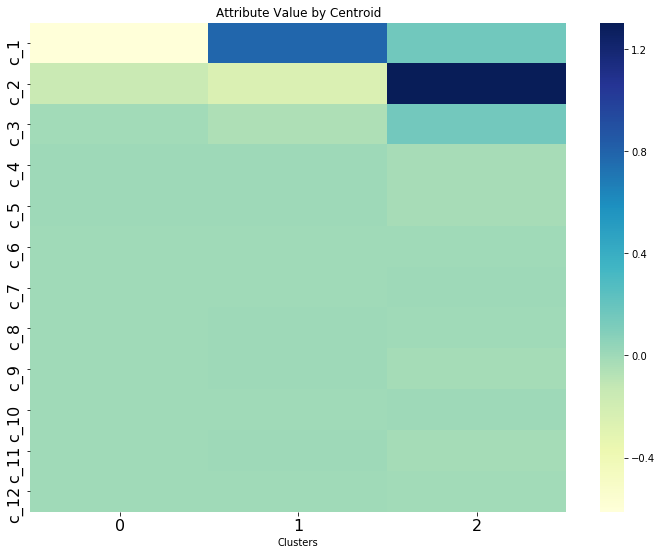

In [40]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Clusters")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

From the heatmap above, we see that:
- Cluster 0 is very low in component 1 and 2.
- Cluster 1 has a very high value for component 1, and low for component 2. 
- Cluster 2 has a very high value for component 2, followed by components 1 and 3
- The variance between components 4 down to 12 isn't much at all.

Recall that each component is made up of the initial 40 features. We can examine the weights of features of each component using the components_ attribute of the PCA model created earlier. 

By looking at the component makeup and the heatmap, the feature makeup of each cluster can be examined.


In [41]:
# Create a function to display a bar chart showing makeup of a component.

def display_components(component_num, n_weights):
    
    component_num_ = component_num - 1 
    # get the list of weights in the component
    comp_makeup = list(princip_comp[component_num_])
    
    # get the list of features
    features = list(scaled_dataset.columns) 

    # match weights to features in customer_dataset
    components = pd.DataFrame(list(zip(comp_makeup, features)), 
                         columns=['weights', 'features'])

    # The weights are sorted by magnitude, from largest to smallest 
    components['abs_weights']=components['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = components.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(12,9))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

We can examine the feature weight of a component below. For instance, we look at component 2;

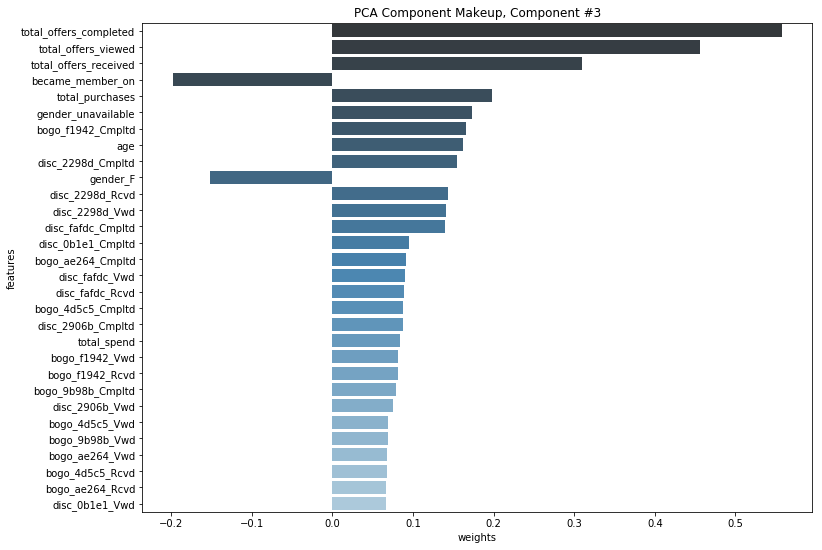

In [57]:
display_components(3, 30) 

### Natural Groupings
We map the clusters back to the customer dataset and transformed dataset to analyze the natural groupings of each customer.


In [47]:
# Map the clusters
customer_dataset['cluster'] = gmm_clusters
transformed_dataframe['cluster'] = gmm_clusters
#customer_dataset.head()


In [48]:
transformed_dataframe.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,cluster
person,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,-0.615340,-0.329664,0.126927,-0.132461,0.069794,0.094561,-0.400128,0.011124,0.299893,0.134199,0.146107,-0.009218,2
00116118485d4dfda04fdbaba9a87b5c,0.151923,1.365501,-0.272429,-0.100232,-0.155957,0.123140,-0.317206,0.230466,-0.123862,0.078571,-0.309598,-0.223620,0
0011e0d4e6b944f998e987f904e8c1e5,0.127473,0.050806,0.223052,0.336513,-0.060218,0.062768,-0.187344,-0.361671,-0.181650,-0.251142,-0.025479,0.448502,1
0020c2b971eb4e9188eac86d93036a77,0.805938,-0.340078,0.027258,-0.201594,0.172849,-0.234618,0.183462,-0.006260,0.436933,-0.064390,-0.182824,-0.109084,1
0020ccbbb6d84e358d3414a3ff76cffd,0.776093,-0.396541,0.066999,0.180301,-0.253869,0.042908,-0.202317,0.236364,-0.098734,-0.342883,0.231328,-0.123198,1


In [49]:
# We define dataframes for each cluster  to examine them
cluster_0 = customer_dataset.loc[customer_dataset['cluster']==0]
cluster_1 = customer_dataset.loc[customer_dataset['cluster']==1]
cluster_2 = customer_dataset.loc[customer_dataset['cluster']==2]

Since gender is a categorical feature, we would use it to easily examine our clusters

In [53]:
cluster_0['gender'].value_counts()

gender_unavailable    2175
Name: gender, dtype: int64

In [55]:
cluster_1['gender'].value_counts()

F    6129
O     114
Name: gender, dtype: int64

In [56]:
cluster_2['gender'].value_counts()

M    8484
O      98
Name: gender, dtype: int64

It seems the clusters were formed based on gender types. This is not the exact clustering wanted as this clustering wouldn't give the variety of information needed.

An improvement on this would be to perform another form of Data processing on the customer dataset. I believe GMM is a good clustering model and can be applied to produce better result, but other algorithms like DBScan could be tried also.